libraries, constants and imports required for the program:
<ul>
<li>Import the enum class created by me</li>
<li>Define the file name</li>
<li>Define if using the default values or allows the user to insert them</li>
<li>Define the default location value</li>
<li>Define the default number of elements value</li>
</ul>

In [267]:
from Enum_data import EnumData
import matplotlib.pyplot as plt

FILE_INPUT = "dati.csv"
ALLOW_USER_INPUT = 0
CITY = "Rome"
N = 5

This function is used to fill data missing as described by the rule

In [268]:
def fill_values(data:list[list], start:int, stop:int, first:float, last:float, col:int)->None:            
    while start < stop:
        data[start][col] = round((first+last)/2,3)
        first = data[start][col]
        start+=1

This function reads the file, drops the first line and fills the missing values: <br>
it creates the two enums required (one for temperature, one for missing values) <br>
if a measurement is missing the data are read until a the next usable value is found <br>


In [269]:
def read_file(FILE_INPUT:str) -> list[list[str, float, float, str, str, str, str]]:
    data = []

    with open(FILE_INPUT, "r", encoding='UTF-8') as fp:
        fp.readline()

        enumData = EnumData()
        missingTemp=-1
        missingDelta=-1


        for i, line in enumerate(fp):
            line = line.strip().split(",")
            try:
                line[enumData.AVG_TEMP] = round(float(line[enumData.AVG_TEMP]), 3)
            except ValueError:
                missingTemp = i if missingTemp == -1 else missingTemp

            try:
                line[enumData.AVG_DELTA] = round(float(line[enumData.AVG_DELTA]),3)
            except ValueError:
                missingDelta = i if missingDelta == -1 else missingDelta

            data.append(line)

            if isinstance(line[enumData.AVG_TEMP], float) and missingTemp != -1:
                fill_values(data, missingTemp, i,
                        data[missingTemp - 1][enumData.AVG_TEMP]
                        if missingTemp > 1
                        else 0,
                    line[enumData.AVG_TEMP], enumData.AVG_TEMP) 
                missingTemp = -1


            if isinstance(line[enumData.AVG_DELTA], float) and missingDelta != -1:
                fill_values(data, missingDelta, i,
                        data[missingDelta - 1][enumData.AVG_DELTA]
                        if missingDelta > 1
                        else 0,
                    line[enumData.AVG_DELTA], enumData.AVG_DELTA)
                missingDelta = -1

        if missingTemp != -1:
            fill_values(data, missingTemp, len(data), data[missingTemp - 1][enumData.AVG_TEMP],0, enumData.AVG_TEMP) 
            
        if missingDelta != -1:
            fill_values(data, missingDelta, len(data), data[missingDelta - 1][enumData.AVG_DELTA],0, enumData.AVG_DELTA) 
            

    return data

This function allows the user to input the name of the city and the number of rows wanted

In [270]:
def user_inputs(max:int)->tuple[str, int]:
    n = -1
    city = ""  
    
    while not city:
        city = input("Insert the city to look for : ").strip()
    
    while n < 1 or n>=max:
        try:
            n = int(input("Insert the number of rows : ").strip())
        except ValueError:
            n = -1
        
    return (city, n)
    

This function prints the N coldest and N hottest measurements for the given city

In [271]:
def searchNHottestColdest(data:list[list], info:list[str, int])->None:
    enum = EnumData()
    lista = sorted(filter(lambda x: x[enum.CITY]==info[0], data), key=lambda x:x[enum.AVG_TEMP])
    
    print(f"{info[1]} COLDEST MEASUREMENT FOR {info[0].upper()}")
    for item in lista[:info[1]]:
        print(f"Date = {item[enum.DATE]} \t Temperature = {item[enum.AVG_TEMP]}")
        
    print(f"\n\n{info[1]} HOTTEST MEASUREMENT FOR {info[0].upper()}")
    for item in lista[len(lista)-info[1]:]:
        print(f"Date = {item[enum.DATE]} \t Temperature = {item[enum.AVG_TEMP]}")

This function evaluates both the mean and the variance of a series of temperatures

In [272]:
def evaluate_avg_var(data:list[list[str, float]]) -> list[float, float]:
    avg = sum(item[1] for item in data)/len(data)

    return [round(avg,6), round(sum((item[1]-avg)**2 for item in data)/len(data), 6)]

This function prints on screen the different temperatures registered for cities in a given
list or set

In [273]:
def searchForAnomalies(data:list[list], cities:list[str])->None:
    enum = EnumData()
    diz = dict()
    
    diz = {city:sorted(map(lambda x:[x[enum.DATE], x[enum.AVG_TEMP]], filter(lambda y:y[enum.CITY] == city, data)), key=lambda x:x[0]) for city in cities}
        
    for city in diz:
        plt.hist([y[1] for y in diz[city]], label=city)
    
    plt.title("Average temperature for the cities ")
    plt.xlabel("Average Temperature")
    plt.ylabel("# Counts")
    plt.legend()
    plt.show()
    
    for city in diz:
        [avg, var] = evaluate_avg_var(diz[city]) 
        print(f"city = {city} \t Avg Temperature = {avg} \t Variance ={var} \t Dev Std = {round(var**0.5, 6)}")
    
    

This function plots the given cities converting the temperature from fahrenheit to celsius 

In [274]:
def printWithConversion(data:list[list], citiesCelsius:list[str], citiesFahrenheit:list[str])->None:
    enum = EnumData()
    diz = dict()
    
    cities = set(citiesCelsius).union(citiesFahrenheit)
    
    #diz = ({city:sorted(map(lambda x:[x[enum.DATE], x[enum.AVG_TEMP]], filter(lambda y:y[enum.CITY] == city, data)), key=lambda x:x[0]) for city in citiesCelsius} 
    #       | {city:sorted(map(lambda x:[x[enum.DATE], x[enum.AVG_TEMP]/1.8-32], filter(lambda y:y[enum.CITY] == city, data)), key=lambda x:x[0]) for city in citiesFahrenheit})
    
    
    diz = {city:sorted(
            map(lambda x:[x[enum.DATE], 
                          x[enum.AVG_TEMP] if city in citiesCelsius else x[enum.AVG_TEMP]/1.8-32], 
                filter(lambda y:y[enum.CITY] == city, data)), key=lambda x:x[0]) 
           for city in cities} 
          
    for city in diz:
        plt.hist([y[1] for y in diz[city]], label=city)
    
    plt.title("Average temperature for the cities ")
    plt.xlabel("Average Temperature")
    plt.ylabel("# Counts")
    plt.legend()
    plt.show()
    
    for city in diz:
        [avg, var] = evaluate_avg_var(diz[city]) 
        print(f"city = {city} \t Avg Temperature = {avg} \t Variance ={var} \t Dev Std = {round(var**0.5, 6)}")
    
    

The main function that regulates the code execution:
<ol>
<li>Reads the input data</li>
<li>Checks which values should be used and allows the user to input them</li>
<li>Prints the N coldest/hottest measurements of the previously defined city</li>
<li>Prints the graph that shows the temperature land temperature for the city of Rome and Bangkok </li>
</ol>

5 COLDEST MEASUREMENT FOR ROME
Date = 1942-01-01 	 Temperature = -1.441
Date = 1956-02-01 	 Temperature = -1.304
Date = 1864-01-01 	 Temperature = -1.019
Date = 1830-01-01 	 Temperature = -0.871
Date = 1893-01-01 	 Temperature = -0.783


5 HOTTEST MEASUREMENT FOR ROME
Date = 2012-07-01 	 Temperature = 24.48
Date = 2012-08-01 	 Temperature = 24.731
Date = 1994-08-01 	 Temperature = 24.873
Date = 2003-07-01 	 Temperature = 24.998
Date = 2003-08-01 	 Temperature = 25.951


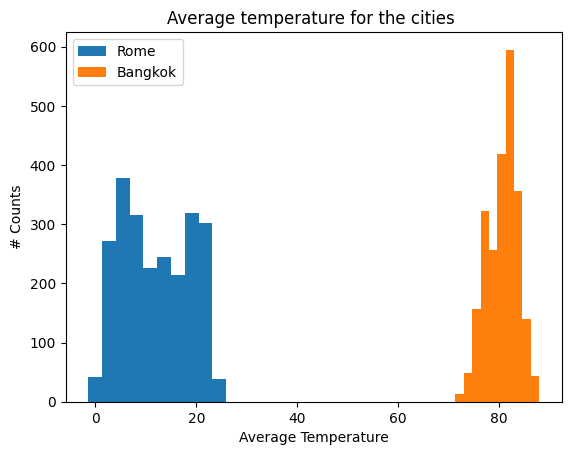

city = Rome 	 Avg Temperature = 12.012435 	 Variance =44.799466 	 Dev Std = 6.69324
city = Bangkok 	 Avg Temperature = 80.727228 	 Variance =9.270265 	 Dev Std = 3.044711


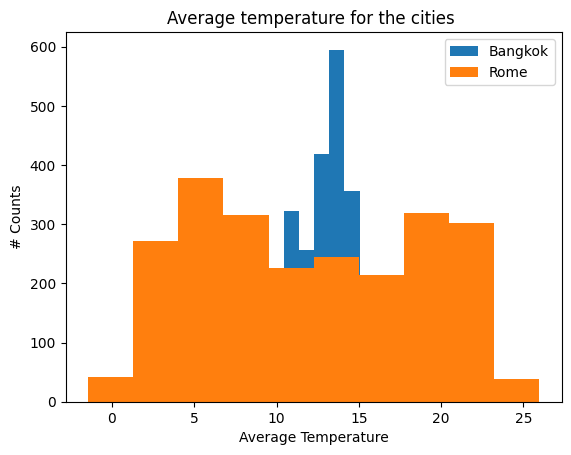

city = Bangkok 	 Avg Temperature = 12.84846 	 Variance =2.861193 	 Dev Std = 1.691506
city = Rome 	 Avg Temperature = 12.012435 	 Variance =44.799466 	 Dev Std = 6.69324


In [275]:
def main()->None:
    data = read_file(FILE_INPUT)
    
    searchNHottestColdest(data, user_inputs(len(data)) if ALLOW_USER_INPUT else (CITY, N))
    
    searchForAnomalies(data, cities=["Rome", "Bangkok"])
    printWithConversion(data, citiesCelsius=["Rome"], citiesFahrenheit=['Bangkok'])
    
        
main()